In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef

from scipy.stats import ttest_1samp
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from statsmodels.stats.multitest import multipletests
from matplotlib_venn import venn2
from scipy.stats import ttest_ind
import math
from scipy.stats import t
import empyrikos as eb

In [2]:
phase1_df=pd.read_csv('/Users/ruisi/Desktop/photosynthesis/code 5.18 /phase1_qn_slopes(5.18).csv' ,low_memory=False)
cts_light = ['20h_HL', '20h_ML']
phase1_df['y2_slope_select'] = phase1_df.apply(
    lambda row: row['y2_slope'] if row['light_regime'] in cts_light else row['y2_slope_on'],
    axis=1
)

In [44]:
phase1_df = phase1_df.copy()

# pooled_map = {
#     '20h_ML': None,  
#     '20h_HL': 'HL/4h',
#     '10min-10min': '20min',
#     '2h-2h': 'HL/4h',
#     '1min-1min': '2min/1min',
#     '30s-30s': '2min/1min',
# }

pooled_map = {
    '20h_ML': None,  
    '20h_HL': 'HL/2h',
    '10min-10min': '10min-10min',
    '2h-2h': 'HL/2h',
    '1min-1min': '1min/30s',
    '30s-30s': '1min/30s',
}
# pooled_map = {
#     '20h_ML': '20h_ML',  
#     '20h_HL': 'HL/2h',
#     '10min-10min': '10min-10min',
#     '2h-2h': 'HL/2h',
#     '1min-1min': '1min/30s',
#     '30s-30s': '1min/30s',
# }


phase1_df['pooled_light_regime'] = phase1_df['light_regime'].map(pooled_map)

# Optionally drop rows with None (i.e., discarded regimes)
phase1_df1 = phase1_df[phase1_df['pooled_light_regime'].notna()]

In [45]:
wt_df = phase1_df1[phase1_df1['mutant_ID'] == 'WT']
mutant_df = phase1_df1[phase1_df1['mutant_ID'] != 'WT']

## paired t test(gene)

In [46]:
paired_gene_results = []

#  — average mutants per plate × light_regime
plate_gene_means = (
    mutant_df
    .groupby(['mutated_genes', 'plate', 'light_regime', 'pooled_light_regime'])['y2_slope_select']
    .mean()
    .reset_index()
)

# — compute per-plate deltas vs WT
deltas_list = []
for _, row in plate_gene_means.iterrows():
    wt_vals = wt_df[
        (wt_df['plate'] == row['plate']) &
        (wt_df['light_regime'] == row['light_regime'])
    ]['y2_slope_select'].dropna()

    if wt_vals.empty:
        continue

    delta = row['y2_slope_select'] - wt_vals.mean()
    deltas_list.append({
        'mutated_genes': row['mutated_genes'],
        'pooled_light_regime': row['pooled_light_regime'],
        'plate': row['plate'],
        'delta': delta
    })

deltas_df = pd.DataFrame(deltas_list)

#  aggregate per gene × pooled_light_regime
for (gene, pooled_regime), group in deltas_df.groupby(['mutated_genes', 'pooled_light_regime']):
    deltas = group['delta'].values
    if len(deltas) < 2:
        continue

    paired_gene_results.append({
        'mutated_genes': gene,
        'pooled_light_regime': pooled_regime,
        'n_replicates': len(deltas),
        'delta_mean': deltas.mean(),
        'delta':deltas,
        'se_hat': deltas.std(ddof=1) / np.sqrt(len(deltas))  # SEM
    })

paired_gene_df = pd.DataFrame(paired_gene_results).copy()

In [47]:
# Prepare inputs for EPB

paired_gene_df["df"] = paired_gene_df["n_replicates"] - 1
paired_gene_df["se_hat_sq"] = (paired_gene_df["se_hat"] ** 2)

# guard against zero/NaN SEs
paired_gene_df.loc[~np.isfinite(paired_gene_df["se_hat_sq"]) | (paired_gene_df["se_hat_sq"] <= 0), "se_hat_sq"] = 1e-12
paired_gene_df.loc[paired_gene_df["df"] < 1, "df"] = 1  

In [35]:
paired_gene_df

,mutated_genes,pooled_light_regime,n_replicates,delta_mean,delta,se_hat,df,se_hat_sq
0,Cre01.g000650,20min,2,-0.001089,"[-0.0005335959333709667, -0.001644207794421667]",0.000555,1,3.083647e-07
1,Cre01.g000650,2min/1min,4,-0.001205,"[-0.0017943928827527332, 0.0009740898457707, -...",0.000748,3,5.601086e-07
2,Cre01.g000650,HL/4h,4,-0.001284,"[-0.003214987001991967, -0.0007487271191550329...",0.000655,3,4.289141e-07
3,Cre01.g001150,20min,2,-0.000692,"[-0.0007163628211891667, -0.000667858375438]",0.000024,1,5.881703e-10
4,Cre01.g001150,2min/1min,4,0.000546,"[0.0011576860931224332, 0.0001423516108541666,...",0.000305,3,9.276631e-08
...,...,...,...,...,...,...,...,...
9085,"unknown_chrom,Cre12.g544662",HL/4h,2,0.000919,"[0.002198452653030967, -0.0003604339323720661]",0.001279,1,1.636975e-06
9086,"unknown_chrom,Cre16.g688901",2min/1min,2,-0.001028,"[-0.0010528296302101004, -0.0010032984918937596]",0.000025,1,6.133334e-10
9087,"unknown_chrom,Cre16.g688901",HL/4h,2,-0.000695,"[-0.00026989104081796703, -0.0011199016469930667]",0.000425,1,1.806295e-07
9088,"unknown_chrom,Cre17.g726983",2min/1min,2,-0.000195,"[0.00016112193367153328, -0.0005501468080542335]",0.000356,1,1.264758e-07


In [48]:
from statsmodels.stats.multitest import multipletests

rows = []

for regime, g in paired_gene_df.groupby("pooled_light_regime"):
    r = eb.epb_ttest(
        beta_hat=g["delta_mean"].to_numpy(),
        se_hat_squared=g["se_hat_sq"].to_numpy(),
        df=g["df"].to_numpy(),
        alpha=0.05,
    )

    g = g.copy()
    p_two = getattr(r, "pvalues", np.nan)

    # Convert to one-sided: H1: delta_mean < 0
    one_sided = np.where(
        g["delta_mean"] < 0,
        p_two / 2,
        1 - (p_two / 2)
    )

    g["p_value"] = one_sided

    # Apply BH correction to the one-sided p-values
    g["p_adj"] = multipletests(g["p_value"], method="fdr_bh")[1]

    # # Keep all original columns + new p_value/p_adj
    # g = g[["mutant_IDs", "mutated_genes", "pooled_light_regime",
    #        "n_replicates", "delta_mean", "se_hat", "df",
    #        "se_hat_sq", "p_value", "p_adj"]]

    rows.append(g)

# Final concatenated DataFrame
epb_by_regime2 = pd.concat(rows, ignore_index=True)


 iter        p_obj        d_obj |  abs_gap    x_feas    z_feas |      tau       kap        mu | dir_res     prox  step     alpha
    0   2.3115e-02  -5.4891e+02 | 4.17e+03  3.47e+02  2.71e+00 | 1.00e+00  1.00e+00  1.00e+00 |
    1  -1.1471e+00  -5.5599e+02 | 3.96e+03  3.51e+02  2.74e+00 | 9.40e-01  1.01e+00  9.50e-01 | 1.1e-11  3.2e-01  co-a  5.00e-02
    2  -2.7186e+00  -5.6029e+02 | 3.77e+03  3.52e+02  2.76e+00 | 8.88e-01  1.02e+00  9.03e-01 | 1.5e-12  2.8e-01  co-a  5.00e-02
    3  -7.4322e+00  -5.6608e+02 | 3.39e+03  3.53e+02  2.76e+00 | 7.98e-01  1.02e+00  8.12e-01 | 2.2e-12  5.7e-01  co-a  1.00e-01
    4  -1.6018e+01  -5.7591e+02 | 3.05e+03  3.54e+02  2.77e+00 | 7.16e-01  1.02e+00  7.31e-01 | 1.2e-11  1.6e-01  co-a  1.00e-01
    5  -2.7887e+01  -5.8792e+02 | 2.75e+03  3.54e+02  2.77e+00 | 6.44e-01  1.02e+00  6.58e-01 | 4.6e-12  3.6e-02  co-a  1.00e-01
    6  -4.4532e+01  -6.0450e+02 | 2.47e+03  3.54e+02  2.77e+00 | 5.80e-01  1.02e+00  5.92e-01 | 1.5e-11  5.4e-02  co-a  1.00e-01


In [37]:
epb_by_regime2 

,mutated_genes,pooled_light_regime,n_replicates,delta_mean,delta,se_hat,df,se_hat_sq,p_value,p_adj
0,Cre01.g000650,20min,2,-0.001089,"[-0.0005335959333709667, -0.001644207794421667]",0.000555,1,3.083647e-07,0.031942,0.526134
1,Cre01.g001150,20min,2,-0.000692,"[-0.0007163628211891667, -0.000667858375438]",0.000024,1,5.881703e-10,0.075352,0.536264
2,Cre01.g001800,20min,2,0.000981,"[0.0012457745276691335, 0.0007167727156636339]",0.000265,1,6.996073e-08,0.966025,0.986229
3,Cre01.g002787,20min,3,0.000154,"[-0.00011375627834850008, -0.00074942811397826...",0.000614,2,3.764324e-07,0.611064,0.896907
4,Cre01.g002861,20min,4,-0.000138,"[0.00022065502130303328, -0.0004345340343475, ...",0.000186,3,3.464593e-08,0.351140,0.758712
...,...,...,...,...,...,...,...,...,...,...
9085,"unknown_chrom,Cre08.g366101",HL/4h,2,-0.000293,"[-0.0009268686612617328, 0.0003413205666735332]",0.000634,1,4.020760e-07,0.287983,0.500181
9086,"unknown_chrom,Cre09.g389319",HL/4h,2,-0.000603,"[-0.0013606494886553664, 0.0001537123681682002]",0.000757,1,5.733230e-07,0.147721,0.318152
9087,"unknown_chrom,Cre12.g544662",HL/4h,2,0.000919,"[0.002198452653030967, -0.0003604339323720661]",0.001279,1,1.636975e-06,0.881193,0.989420
9088,"unknown_chrom,Cre16.g688901",HL/4h,2,-0.000695,"[-0.00026989104081796703, -0.0011199016469930667]",0.000425,1,1.806295e-07,0.089627,0.227842


In [38]:
def plot_pvalue_histograms_per_regime(ttest_results_all, bins=30):
    """
    Plot histograms of raw p-values for each light regime in a specified order.
    """
    # Define your desired order
    regime_order=['HL/2h','10min-10min','1min/30s']
    
    n_regimes = len(regime_order)
    n_cols = 3
    n_rows = (n_regimes + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), constrained_layout=True)
    axes = axes.flatten()

    for i, regime in enumerate(regime_order):
        ax = axes[i]
        subset = ttest_results_all[ttest_results_all['pooled_light_regime'] == regime]
        sns.histplot(subset['p_value'], bins=bins, kde=False, color='steelblue', ax=ax)
        ax.set_title(f'{regime}')
        ax.set_xlabel('Raw p-value')
        ax.set_ylabel('Count')
        ax.set_xlim(0, 1)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle('Histogram of Raw P-values', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

In [19]:
def plot_BH_pvalue_histograms_per_regime(ttest_results_all, bins=30):
    """
    Plot histograms of raw p-values for each light regime in a specified order.
    """
    # Define your desired order
    regime_order=['HL/2h','10min-10min','1min/30s']
    
    n_regimes = len(regime_order)
    n_cols = 3
    n_rows = (n_regimes + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), constrained_layout=True)
    axes = axes.flatten()

    for i, regime in enumerate(regime_order):
        ax = axes[i]
        subset = ttest_results_all[ttest_results_all['pooled_light_regime'] == regime]
        sns.histplot(subset['p_adj'], bins=bins, kde=False, color='orange', ax=ax)
        ax.set_title(f'{regime}')
        ax.set_xlabel('adj_p_value')
        ax.set_ylabel('Count')
        ax.set_xlim(0, 1)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle('Histogram of Adjusted P-values by Light Regime', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

/var/folders/t_/cq8kc3m112ndc44tfq9_3pgh0000gn/T/ipykernel_13497/279784927.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


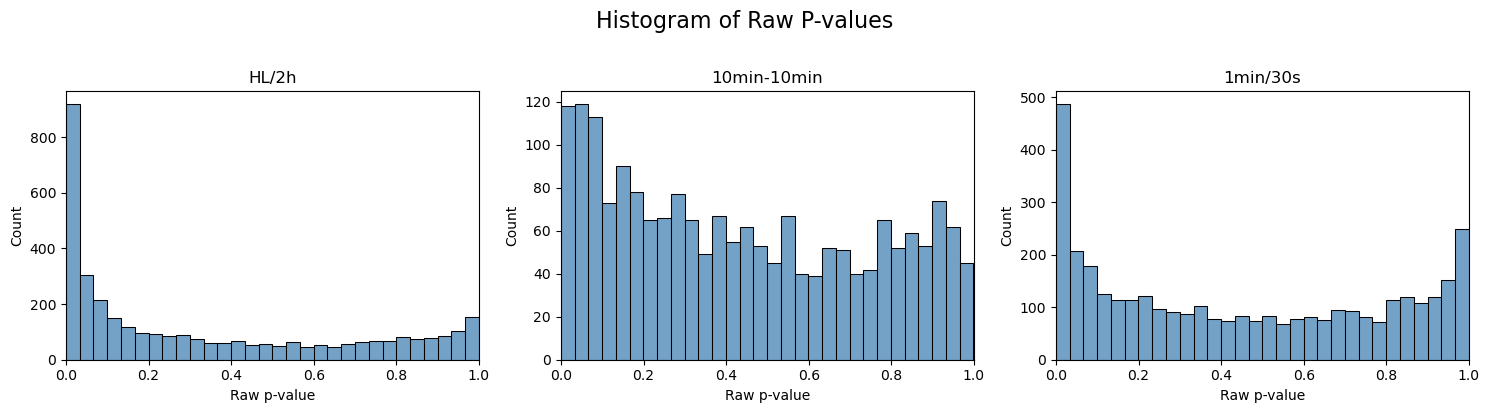

In [49]:
plot_pvalue_histograms_per_regime(epb_by_regime2)

/var/folders/t_/cq8kc3m112ndc44tfq9_3pgh0000gn/T/ipykernel_13497/3220965384.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


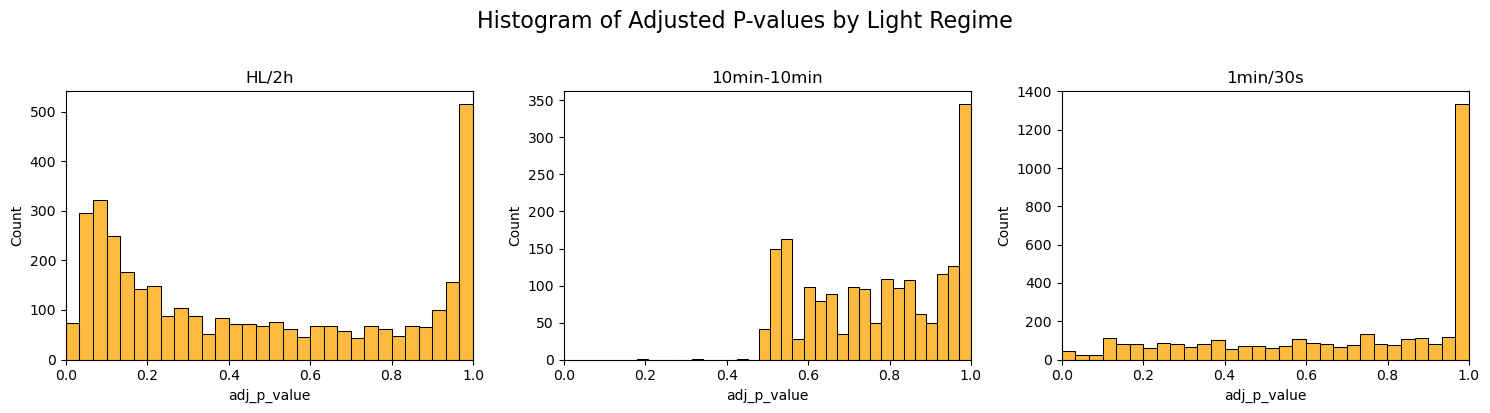

In [21]:
plot_BH_pvalue_histograms_per_regime(epb_by_regime2)

In [40]:
from matplotlib import cm
def plot_volcano_per_light_regime1(ttest_results,
                                   p_thresh=1e-5,
                                   regimes_order=None,
                                   figsize=(14, 14),
                                   title_prefix='Volcano Plot'):
    
    # Compute effect size and -log10(p-adj)
    ttest_results['effect_size'] = ttest_results['delta_mean']
    ttest_results['neg_log10_p'] = -np.log10(ttest_results['p_adj'])

    # Define expected gene sets

    expected_10min =['Cre12.g531900']
    expected_1min_30s = {'Cre12.g531900', 'Cre16.g661200', 'Cre07.g314800', 'Cre13.g588150', 'Cre05.g235800','Cre15.g635800','Cre06.g278110'}
    expected_HL_2h = {'Cre12.g531900','Cre02.g105350', 'Cre07.g323450'}

    # Combine all expected genes and assign unique colors
    all_expected_genes = sorted(set.union(expected_1min_30s, expected_HL_2h))
    expected_colors = sns.color_palette('tab20', n_colors=len(all_expected_genes))
    gene_to_color = dict(zip(all_expected_genes, expected_colors))

    # Determine plotting order
    if regimes_order is None:
        regimes = sorted(ttest_results['pooled_light_regime'].unique())
    else:
        regimes = regimes_order

    # Prepare subplot layout
    n = len(regimes)
    ncols = 2
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for i, regime in enumerate(regimes):
        ax = axes[i]
        df = ttest_results[ttest_results['pooled_light_regime'] == regime].copy()

        # Get expected genes per regime
        expected_set = (
            expected_1min_30s if regime == '2min/1min' else
            expected_HL_2h if regime == 'HL/4h' else
            expected_10min if regime=='20min' else
            set()
        )

        df_expected = df[df['mutated_genes'].isin(expected_set)]
        df_others = df[~df['mutated_genes'].isin(expected_set)]

        # Plot background genes
        ax.scatter(df_others['effect_size'], df_others['neg_log10_p'],
                   color='gray', alpha=0.5, label='_nolegend_')

        # Plot expected genes
        for gene in expected_set:
            gene_data = df_expected[df_expected['mutated_genes'] == gene]
            ax.scatter(gene_data['effect_size'], gene_data['neg_log10_p'],
                       color=gene_to_color[gene], label=gene, s=40, alpha=0.9)

        y_thresh_main = -np.log10(p_thresh)
        ax.axhline(y_thresh_main, color='blue', linestyle='--', linewidth=1)
        ax.text(
            x=0.95 * ax.get_xlim()[1],
            y=y_thresh_main + 0.1,
            s=f'p = {p_thresh}',
            color='blue',
            ha='right',
            va='bottom',
            fontsize=10
        )
        
        
        # Threshold 3: p = 0.1
        y_thresh_01 = -np.log10(0.1)
        ax.axhline(y_thresh_01, color='green', linestyle='-.', linewidth=1)
        ax.text(
            x=0.95 * ax.get_xlim()[1],
            y=y_thresh_01 + 0.1,
            s='p = 0.1',
            color='green',
            ha='right',
            va='bottom',
            fontsize=10
        )
        
        # Threshold 3: p = 0.05
        y_thresh_01 = -np.log10(0.05)
        ax.axhline(y_thresh_01, color='green', linestyle='-.', linewidth=1)
        ax.text(
            x=0.95 * ax.get_xlim()[1],
            y=y_thresh_01 + 0.1,
            s='p = 0.05',
            color='green',
            ha='right',
            va='bottom',
            fontsize=10
        )
        # # Threshold 3: p = 0.3
        # y_thresh_01 = -np.log10(0.3)
        # ax.axhline(y_thresh_01, color='green', linestyle='-.', linewidth=1)
        # ax.text(
        #     x=0.95 * ax.get_xlim()[1],
        #     y=y_thresh_01 + 0.1,
        #     s='p = 0.3',
        #     color='green',
        #     ha='right',
        #     va='bottom',
        #     fontsize=10
        # )


        # Set titles and labels
        ax.set_title(f'{title_prefix} — {regime}')
        ax.set_xlabel('Effect Size (Mutant - WT)')
        ax.set_ylabel('-log10(p-adjusted)')

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add unified legend for expected genes
    legend_patches = [Patch(color=gene_to_color[gene], label=gene) for gene in all_expected_genes]
    fig.legend(handles=legend_patches, title='Expected Genes', bbox_to_anchor=(1.02, 0.5), loc='center left')

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout for side legend
    plt.show()

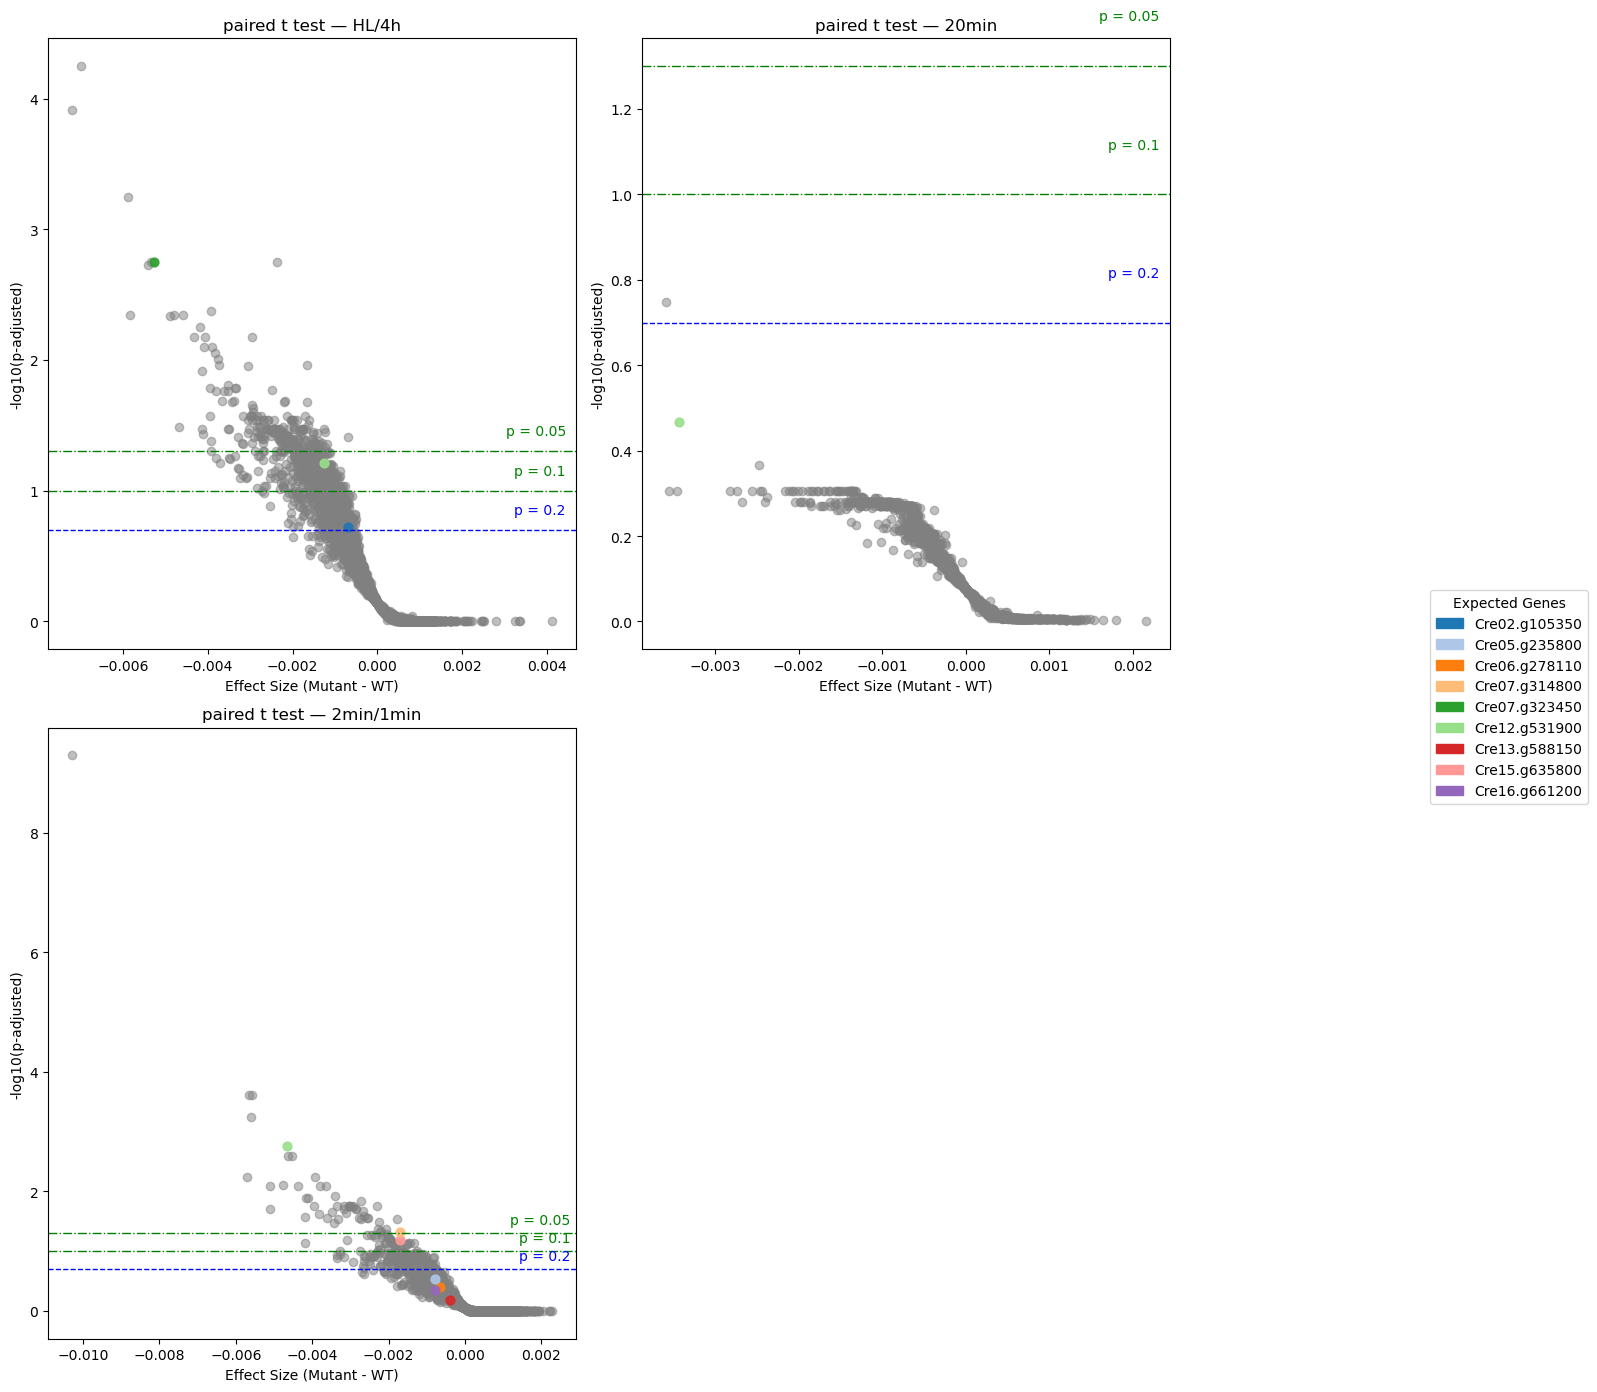

In [42]:
plot_volcano_per_light_regime1(
    epb_by_regime2,
    p_thresh= 0.2,
    regimes_order=[ 'HL/4h','20min' ,'2min/1min'],
    title_prefix='paired t test',
    figsize=(14, 14)

)